In [4]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F
import torch.optim as optim


import os
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

In [22]:
#Function to convert string to one hot encoding
def to_onehot(string):
    ascii_list = []
    for chars in string:
        ascii_list.append(ord(chars))
    onehot_vals = np.eye(128)[ascii_list]
    return onehot_vals, np.array(ascii_list)

In [27]:
b=5
a,_ = to_onehot('abc')
print(np.argmax(a,1))
print(type(np.argmax(a,1)))
print(b)
print(type(b))


[97 98 99]
<class 'numpy.ndarray'>
5
<class 'int'>


In [2]:
file = open("./Data/input.txt")
text = file.readlines()
file.close()

text_array = np.asarray(text)

#Creates list of each song
indicies = np.where(text_array == '<start>\n') #Location of where each abc file starts
data = []
for i in range(len(indicies[0])):
    if i+1 == len(indicies[0]):
        #For the last abc file
        abc = text_array[indicies[0][i]:]
    else:
        abc = text_array[indicies[0][i]:indicies[0][i+1]]
    data.append(''.join(abc))

#print(data[0])
#print(data[1123])

In [3]:
#80 - 20 split on data -> training and validation
#Constants
train_len = int(np.floor(len(data)*0.8))
validation_len = len(data) - train_len

print(train_len)
print(validation_len)

np.random.seed(0)
#Each index references to a single song
indxs = np.asarray(range(len(data)))
print(indxs)
np.random.shuffle(indxs)
print(indxs)

temp = np.asarray(data)
train_data = temp[indxs[0:train_len]]
validation_data = temp[indxs[train_len:]]
print(len(train_data))
print(len(validation_data))

#print(temp[1050])
#print(train_data[2])

899
225
[   0    1    2 ... 1121 1122 1123]
[ 752  893 1050 ...  835  559  684]
899
225


In [ ]:
#Data
onehot_train, train_labels = to_onehot(train_data)
onehot_validation, validation_labels = to_onehot(validation_data)

In [4]:
train_ascii_vals = []
validation_ascii_vals = []

for songs in train_data:
    for chars in songs:
        train_ascii_vals.append(ord(chars))
        
for songs in validation_data:
    for chars in songs:
        validation_ascii_vals.append(ord(chars))
        
#Each character is a row in this notation
onehot_train = np.eye(128)[train_ascii_vals]
train_labels = train_ascii_vals
onehot_validation = np.eye(128)[validation_ascii_vals]
validation_labels = validation_ascii_vals
# print(train_ascii_vals[0])
# print(onehot_train[0])

In [5]:
#LSTM constants
input_size = 128 #num_classes = 128
hidden_size = 128
num_layers = 1
batch_first = True

batch_size = 1
sequence_length = 25


run first in single batches, each batch has 25 chars per(sequence length 25), just run it in order of the train data

In [6]:
class lstm_rnn(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers=1,batch_size=1,
                 sequence_length=25,batch_first = True):
        super(lstm_rnn, self).__init__()
        #Constants
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        
        #Initializing model
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first = batch_first)
        
    def forward(self,data,initial):
        #data = data.view(self.batch_size, self.sequence_length, self.input_size)
        output,hidden = self.lstm(data,initial)
        return output,hidden
        
    def init_hidden(self,zero=1):
        if zero == 0:
            #Random initialization
            initial_hidden = autograd.Variable(torch.randn(self.num_layers,self.batch_size,self.hidden_size))
        else:
            #Zero initialization
            initial_hidden = autograd.Variable(torch.zeros(self.num_layers,self.batch_size,self.hidden_size))
        return initial_hidden
    
    def init_cell(self,zero=1):
        if zero == 0:
            #Random initialization
            initial_cell = autograd.Variable(torch.randn(self.num_layers,self.batch_size,self.hidden_size))
        else:
            #Zero initialization
            initial_cell = autograd.Variable(torch.zeros(self.num_layers,self.batch_size,self.hidden_size))
        return initial_cell
    

In [7]:
lstm = lstm_rnn(input_size,hidden_size,num_layers,batch_size,
                sequence_length,batch_first = batch_first)
print(lstm.input_size)
print(lstm.hidden_size)
print(lstm.batch_size)
print(lstm.sequence_length)
print(lstm.num_layers)
print(lstm)

128
128
1
25
1
lstm_rnn(
  (lstm): LSTM(128, 128, batch_first=True)
)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lstm.parameters(), lr=0.1)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [9]:
#Creates batch indicies, +1 since arange is [,), exclusive last element
batch_indicies = np.arange(0,len(onehot_train)-sequence_length+1,sequence_length)
print(len(batch_indicies))

16061


In [10]:
h_0 = lstm.init_hidden()
c_0 = lstm.init_cell()
states = (h_0,c_0)
loss = []
accuracy = []

#CAN ADD LINEAR LAYER AND BATCH PROCESSING 
for epoch in range(5):
    for indx in batch_indicies:
        optimizer.zero_grad()
        temp_data = onehot_train[indx:indx+25]
        temp_data = torch.from_numpy(temp_data).float()
        temp_data = autograd.Variable(temp_data.view(batch_size,sequence_length,input_size))
    
        #output is of whole sequence, states hidden is same as last element of output, also
        #has cell hidden state
        output, states = lstm(temp_data,states)
        
        h_0 = autograd.Variable(states[0].data, requires_grad=True)
        c_0 = autograd.Variable(states[1].data, requires_grad=True)
        states = (h_0,c_0)
        #hidden = Variable(hidden.data, requires_grad=True)

        
        #Add 1 since we are using the next letter as the label
        labels = autograd.Variable(torch.LongTensor(train_labels[indx+1:indx+25+1]))
        
        #Later try adding a linear layer here
        
        loss_temp = criterion(output.view(sequence_length,input_size),labels)
        loss.append(loss_temp.data)
        loss_temp.backward()
        optimizer.step()
        
        vals,max_indxs = (output.data).max(2)
        acc_temp = (max_indxs==(labels.data)).sum()
        accuracy.append(acc_temp/sequence_length)
        #print(loss)
        #print(accuracy)
    print(epoch)
        

        

0
1
2
3
4


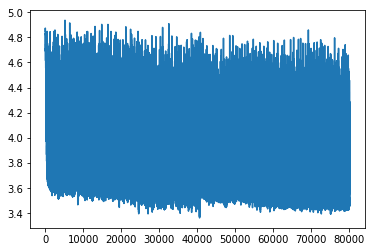

In [11]:
plt.plot(loss)

In [12]:
#write a function for this later 
primer = "<start>\n"
start_token = []
for chars in primer:
    start_token.append(ord(chars))
    
start_token = np.eye(128)[start_token]
start_token = torch.from_numpy(start_token).float()
start_token = autograd.Variable(start_token.view(1,8,input_size))
#print(start_token.argmax(1))

end = "<end>"
end_token = []
for chars in end:
    end_token.append(ord(chars))
    
end_token = np.eye(128)[end_token]

done = 1

#Generating music
h_0 = lstm.init_hidden()
c_0 = lstm.init_cell()
states = (h_0,c_0)
chars = []

#Each loop generates 1 char
for i in range(100):
    output,states = lstm(start_token,states)
    
    h_0 = autograd.Variable(states[0].data, requires_grad=True)
    c_0 = autograd.Variable(states[1].data, requires_grad=True)
    states = (h_0,c_0)
    
    #Currently I am taking the max of the hidden state as the letter that it
    #produces, the TA on piazza said that it is not ideal to take max,
    #can try implementing what he says later
    val,indx = states[0].data.max(2)
    chars.append(indx)
    
    start_token = torch.from_numpy(np.eye(128)[indx]).float()
    start_token = autograd.Variable(start_token.view(1,1,input_size))
    
    #Need to implement a check for "<end>", generation should stop once
    #"<end>" is produced

In [13]:
#Converting back to strings
outputs = []
for letter in chars:
    outputs.append(chr(letter))

print(chars)
print(outputs)


[
 97
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch.LongTensor of size 1x1]
, 
 32
[torch